## SCRAPING DATA DARI GOOGLE PLAYSTORE

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
# !pip install wordcloud
from wordcloud import WordCloud
import pickle

In [3]:
!pip install google-play-scraper

In [18]:
#from google_play_scraper import app

# Melihat semua informasi umum dari aplikasi
#result = app(
#    "com.tokopedia.tkpd",
#    lang = "id",
#    country = "id")

#result

In [9]:
#from google_play_scraper import Sort, reviews

# Buat cek dia keterangannya apa saja (format tanggalnya bagaimana, dll)
#result, continuation_token = reviews(
#    "com.tokopedia.tkpd",
#    lang = "id", 
#    country = "id",
#    sort = Sort.NEWEST, # Sort berdasarkan yang terbaru
#    count = 800000)

#result[800000-1]

In [10]:
#result, _ = reviews(
#    "com.tokopedia.tkpd",
#    continuation_token = continuation_token) 

#result

# continuation_token -> Untuk menampilkan data setelahnya (lihat username-nya beda)
# Untuk meneruskan scraping ke data selanjutnya (nanti bisa diubah saja namanya misal jadi result1, result2, dst)
# Banyaknya sesuai nilai "count" yang sudah didefinisikan sebelumnya

In [10]:
from google_play_scraper import Sort, reviews_all

In [12]:
result_tokped = reviews_all(
    "com.tokopedia.tkpd",
    lang = "id",
    country = "id",
    sort = Sort.NEWEST)

In [14]:
len(result_tokped)

In [15]:
result_tokped[len(result_tokped) - 1]

### Simpan Hasil Scraping Secara Langsung

In [16]:
# Simpan data menjadi file json
with open("tokopedia.json", "w") as f:
    json.dump(result_tokped, f, indent = 2, default = str) 

# indent -> Indentasi berapa spasi

In [17]:
#!cat tokopedia.json

In [14]:
# Membaca data dalam bentuk tabel
adf = pd.read_json("tokopedia.json")

In [15]:
df.head()

In [16]:
df.shape

In [17]:
df.columns

In [22]:
df.to_csv("tokopedia.csv")

In [23]:
tokped = pd.read_csv("tokopedia.csv")

In [24]:
tokped.head()

### Simpan Hasil Scraping Dalam Google Drive

In [25]:
from google.colab import drive
drive.mount('/content/drive')

In [26]:
# Simpan data menjadi file json ke Google Drive
with open("/content/drive/My Drive/tokopedia.json", "w") as f:
    json.dump(result_tokped, f, indent = 2, default = str) 

# indent -> Indentasi berapa spasi

In [27]:
df.to_csv("/content/drive/My Drive/tokopedia.csv")

In [28]:
tokped = pd.read_csv("/content/drive/My Drive/tokopedia.csv", index_col = 0)

In [29]:
tokped.tail()

### Ambil Data dari 26 Feb 2020 - 26 Feb 2021

In [30]:
tokped.shape # Data diambil 1 Maret 2021 (17:28 WIB)

In [31]:
tokped.columns

In [32]:
# Ubah data tanggal menjadi data datetime
tokped["at"] = pd.to_datetime(tokped["at"])

In [33]:
tokped.info()

In [34]:
# Ambil hanya date-nya saja
tokped["date"] = tokped["at"].dt.date
tokped["date"].head()

In [35]:
a = pd.date_range(start = "2020-02-26", end = "2021-02-26")

from datetime import date, timedelta

start_date = date(2020, 2, 26)
end_date = date(2021, 2, 26)
delta = timedelta(days = 1)
tokped_pakai = pd.DataFrame(columns = list(tokped.columns))
while start_date <= end_date:
    x = tokped[tokped["date"] == start_date]
    tokped_pakai = pd.concat([tokped_pakai, x])
    start_date += delta

'\nfrom datetime import date, timedelta\nimport numpy as np\n\nstart_date = date(2020, 2, 26)\nend_date = date(2021, 2, 26)\ndelta = timedelta(days = 1)\ntokped_pakai = pd.DataFrame(columns = list(tokped.columns))\nwhile start_date <= end_date:\n    x = tokped[tokped["date"] == start_date]\n    tokped_pakai = pd.concat([tokped_pakai, x])\n    start_date += delta\n'

In [36]:
tokped_pakai.head(2)

In [37]:
tokped_pakai = tokped_pakai.reset_index(drop = True)
tokped_pakai.tail(2)

In [38]:
tokped_pakai.shape

In [39]:
tokped_pakai = tokped_pakai[["content", "score"]]
tokped_pakai.head()

In [40]:
#tokped_pakai.to_csv("/content/drive/My Drive/content tokopedia 26 Feb 2020-2021.csv", index = False)
tokped_pakai.to_csv("content tokopedia 26 Feb 2020-2021.csv", index = False)

## MENYIAPKAN DATA

In [2]:
tokped_oke = pd.read_csv("content tokopedia 26 Feb 2020-2021.csv")
tokped_oke.head()

,content,score
0,Cukup puas dengan toped,4
1,The best online shopping Indonesia,5
2,Ok,5
3,Bagus,4
4,"Siiip , cepat dan tepat",5


In [3]:
tokped_oke.shape

(547589, 2)

In [4]:
# Simpan salinan untuk data asli
tokped = tokped_oke.copy()

### 1. Membuat Kolom Sentimen

In [5]:
# Buat kolom baru berisi if-else untuk sentimen "positif" & "negatif" berdasarkan kolom score
# score <= 3 -> negatif (0)
# score > 3 -> positif (1)

tokped["sentimen"] = np.where(tokped["score"] <= 3, 0, 1)
tokped.head()

,content,score,sentimen
0,Cukup puas dengan toped,4,1
1,The best online shopping Indonesia,5,1
2,Ok,5,1
3,Bagus,4,1
4,"Siiip , cepat dan tepat",5,1


In [7]:
# Ternyata tidak seimbang
tokped["sentimen"].value_counts()

1    485361
0     62228
Name: sentimen, dtype: int64

In [9]:
tokped["content"].value_counts()

Mantap                                                                                                                                                             14538
Bagus                                                                                                                                                              11626
Sangat membantu                                                                                                                                                     9957
Good                                                                                                                                                                9031
Ok                                                                                                                                                                  8493
                                                                                                                                                           

### 2. Resampling

In [10]:
# Dilakukan resampling (Pakai 3k-3k)
s1 = tokped[tokped["sentimen"] == 0].sample(3000, replace = False, random_state = 0)
s2 = tokped[tokped["sentimen"] == 1].sample(3000, replace = False, random_state = 0)
tokped = pd.concat([s1, s2])

In [11]:
print(tokped.shape)
print(tokped["sentimen"].value_counts())

(6000, 3)
1    3000
0    3000
Name: sentimen, dtype: int64


In [12]:
tokped.head()

,content,score,sentimen
410574,Aku meh donwload lagu malah metu link mengkene,1,0
28081,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0
536023,bagus,3,0
406433,Saya membeli pelatihan membuat dan menjual mas...,3,0
464980,Toko pedia ngpusi,1,0


In [13]:
tokped = tokped.reset_index(drop = True)
tokped.head()

,content,score,sentimen
0,Aku meh donwload lagu malah metu link mengkene,1,0
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0
2,bagus,3,0
3,Saya membeli pelatihan membuat dan menjual mas...,3,0
4,Toko pedia ngpusi,1,0


In [14]:
# DATA YANG DIGUNAKAN
tokped.to_csv("content hasil resampling (3k per sentimen).csv", index = False)
#tokped.to_excel("content hasil resampling (3k per sentimen).xlsx", index = False)

## EKSPLORASI DATA

In [124]:
tokped = pd.read_csv("content hasil resampling (3k per sentimen).csv")
tokped.head()

,content,score,sentimen
0,Aku meh donwload lagu malah metu link mengkene,1,0
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0
2,bagus,3,0
3,Saya membeli pelatihan membuat dan menjual mas...,3,0
4,Toko pedia ngpusi,1,0


In [125]:
tokped.columns

Index(['content', 'score', 'sentimen'], dtype='object')

In [126]:
# Word Cloud Data Asli (Sebelum Diolah)

word_sebelum_diolah = pd.Series(" ".join(tokped["content"]).split())
len(word_sebelum_diolah)

66563

In [127]:
tokped.shape

(6000, 3)

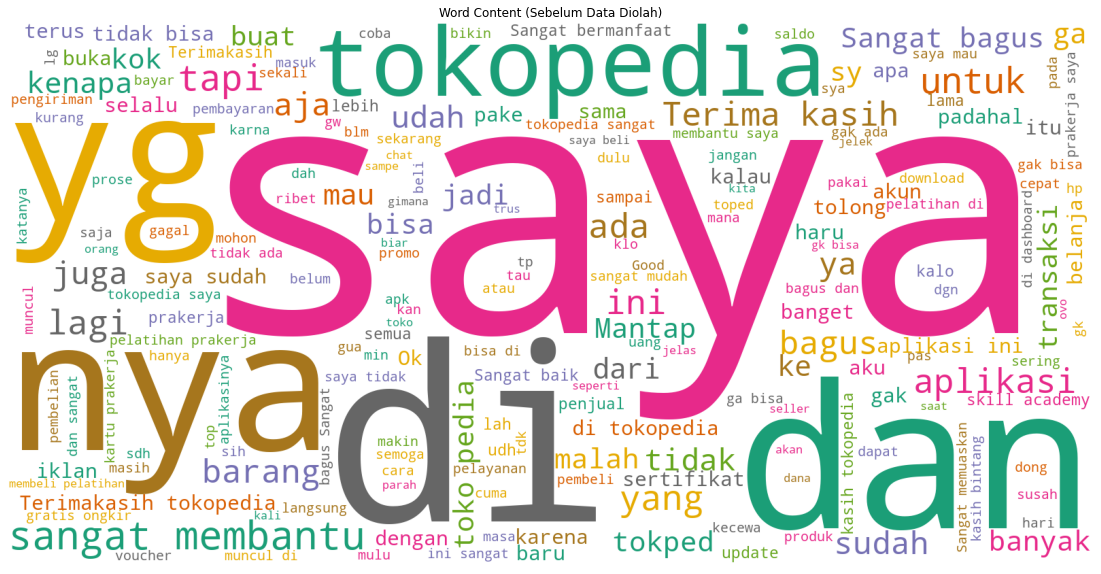

In [128]:
# WORDCLOUD CONTENT SECARA KESELURUHAN (DATA SEBELUM DIOLAH)

dat_sebelum_diolah = " ".join(word_sebelum_diolah)

# Bigram (per dua kata) -> "collocations = True"
wordcloud_sblm = WordCloud(background_color = "white", mode = "RGB", width = 1600, height = 800, colormap = "Dark2").generate(dat_sebelum_diolah)
plt.figure(figsize = (20, 10))
plt.title("Word Content (Sebelum Data Diolah)")
plt.imshow(wordcloud_sblm)
plt.axis("off")
plt.show()

In [129]:
word_sebelum_diolah.value_counts().nlargest(10)

di           1521
saya         1296
dan           963
sangat        651
bisa          645
tokopedia     632
Sangat        581
yg            563
nya           544
ada           528
dtype: int64

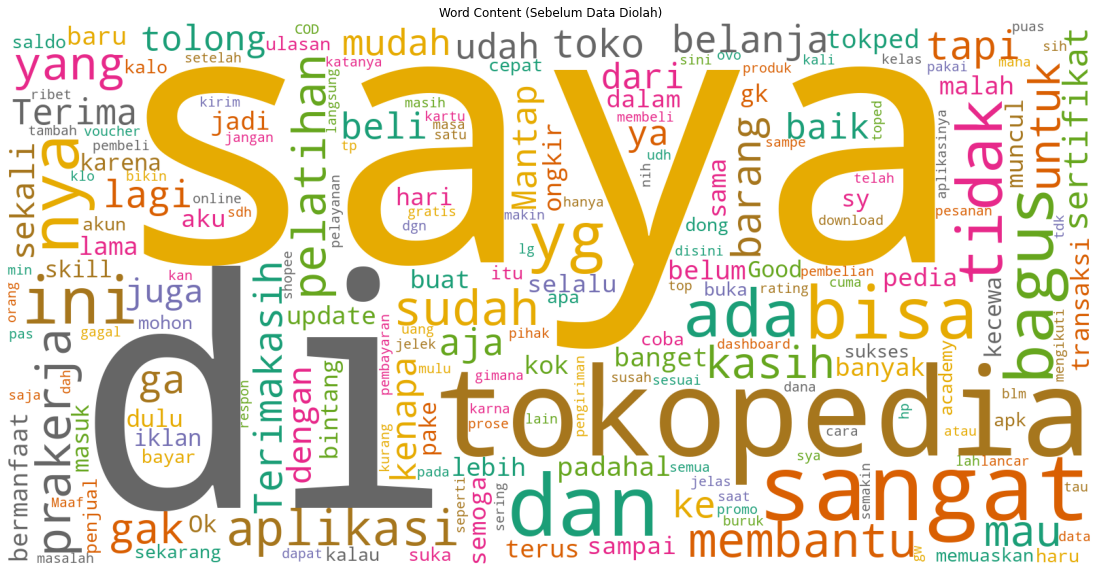

In [130]:
# WORDCLOUD CONTENT SECARA KESELURUHAN (DATA SEBELUM DIOLAH)

dat_sebelum_diolah = " ".join(word_sebelum_diolah)

# Unigram (per satu kata) -> "collocations = False"
wordcloud_sblm = WordCloud(background_color = "white", mode = "RGB", width = 1600, height = 800, colormap = "Dark2", collocations = False).generate(dat_sebelum_diolah)
plt.figure(figsize = (20, 10))
plt.title("Word Content (Sebelum Data Diolah)")
plt.imshow(wordcloud_sblm)
plt.axis("off")

plt.savefig("Visualisasi/Wordcloud Data Asli (Kotor).png")

plt.show()

### Grafik Komposisi Score

In [131]:
tokped_score = tokped["score"].value_counts()
tokped_score

5    2807
1    1807
3     724
2     469
4     193
Name: score, dtype: int64

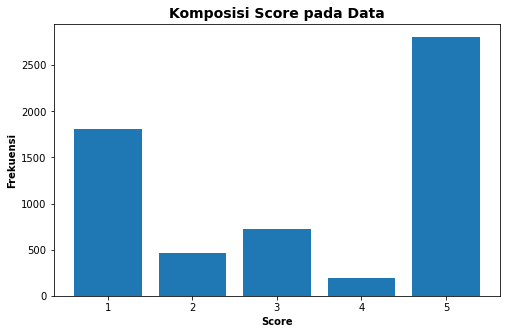

In [132]:
# KOMPOSISI SCORE PADA DATA
tokped_score_x = tokped_score.index
tokped_score_y = tokped_score.values

plt.figure(figsize = (8, 5))
plt.bar(tokped_score_x, tokped_score_y)
plt.xlabel("Score", fontweight = 'bold')
plt.ylabel("Frekuensi", fontweight = 'bold')
plt.title("Komposisi Score pada Data", fontweight = 'bold', fontsize = 14)

plt.savefig("Visualisasi/Komposisi Score pada Data.png")

plt.show()

### Word Cloud Sentimen (Data Sebelum Diolah)

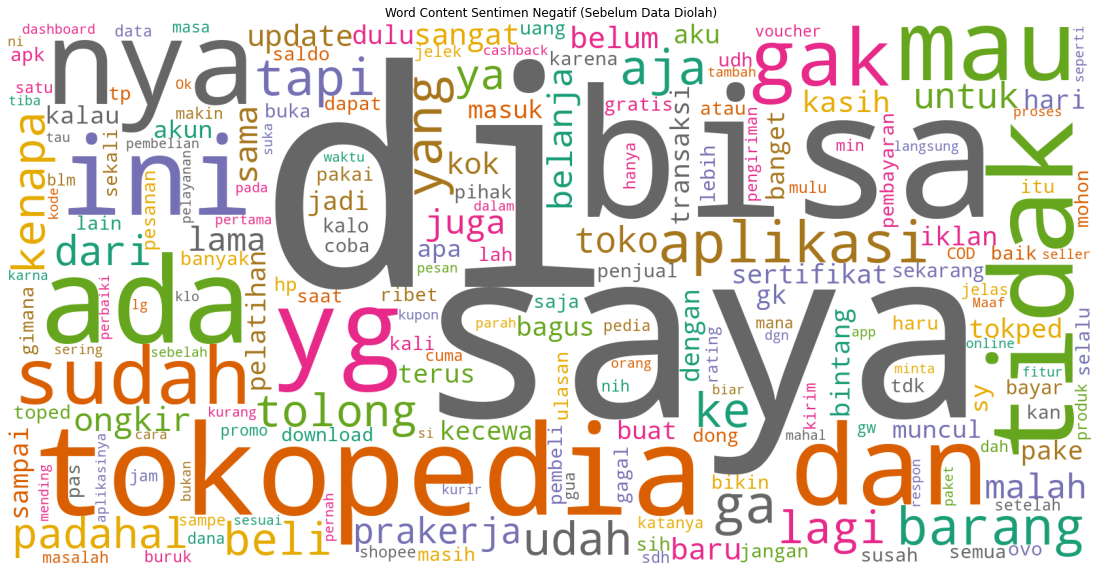

In [133]:
# 1. WORDCLOUD CONTENT SENTIMEN NEGATIF

word_sebelum_diolah_negatif = pd.Series(" ".join(tokped[tokped["sentimen"] == 0]["content"]).split())
dat_sebelum_diolah_negatif = " ".join(word_sebelum_diolah_negatif)

# Unigram (per satu kata) -> "collocations = False"
wordcloud_sblm_negatif = WordCloud(background_color = "white", mode = "RGB", width = 1600, height = 800, colormap = "Dark2", collocations = False).generate(dat_sebelum_diolah_negatif)
plt.figure(figsize = (20, 10))
plt.title("Word Content Sentimen Negatif (Sebelum Data Diolah)")
plt.imshow(wordcloud_sblm_negatif)
plt.axis("off")

plt.savefig("Visualisasi/Wordcloud Data Asli (Kotor) Sentimen Negatif.png")

plt.show()

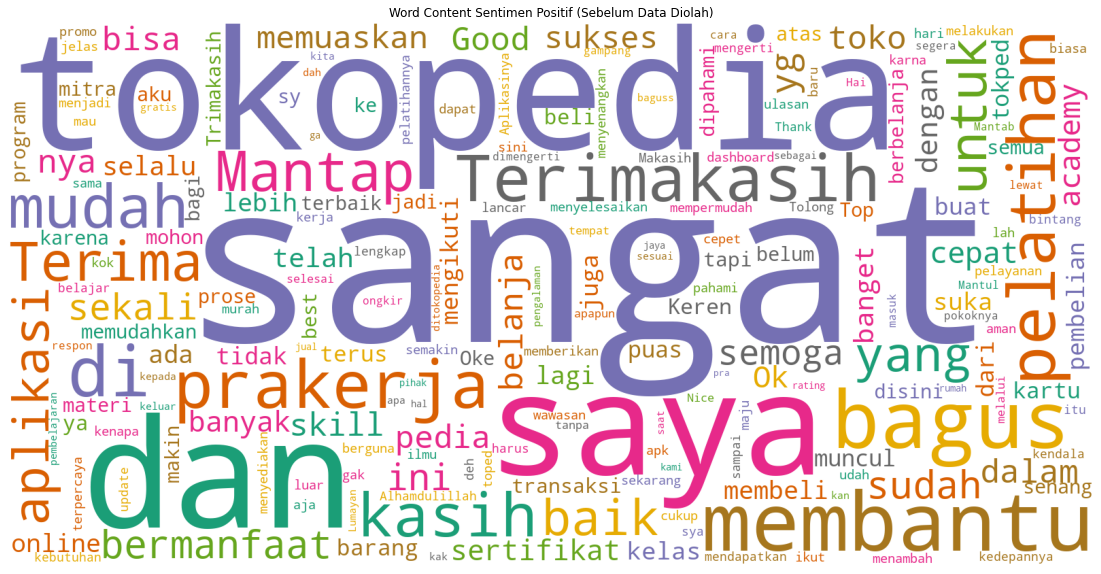

In [134]:
# 2. WORDCLOUD CONTENT SENTIMEN POSITIF

word_sebelum_diolah_positif = pd.Series(" ".join(tokped[tokped["sentimen"] == 1]["content"]).split())
dat_sebelum_diolah_positif = " ".join(word_sebelum_diolah_positif)

# Unigram (per satu kata) -> "collocations = False"
wordcloud_sblm_positif = WordCloud(background_color = "white", mode = "RGB", width = 1600, height = 800, colormap = "Dark2", collocations = False).generate(dat_sebelum_diolah_positif)
plt.figure(figsize = (20, 10))
plt.title("Word Content Sentimen Positif (Sebelum Data Diolah)")
plt.imshow(wordcloud_sblm_positif)
plt.axis("off")

plt.savefig("Visualisasi/Wordcloud Data Asli (Kotor) Sentimen Positif.png")

plt.show()

## PREPROCESSING DATA

### 1. Case Folding

In [135]:
tokped_oke = tokped.copy() # Biar punya cadangan

In [136]:
tokped.head()

,content,score,sentimen
0,Aku meh donwload lagu malah metu link mengkene,1,0
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0
2,bagus,3,0
3,Saya membeli pelatihan membuat dan menjual mas...,3,0
4,Toko pedia ngpusi,1,0


In [137]:
for i in range(len(tokped)):
    if type(tokped["content"][i]) != str:
        print(str(i), "Bukan string")
        
# Sudah dalam bentuk string semua

In [38]:
# Case Folding

def clean_content(content):
    import string, re
    
    content = content.lower() # menjadikan lowercase
    content = re.sub("[^a-z]", " ", content) # hapus semua karakter kecuali a-z
    content = re.sub("\t", " ", content) # mengganti tab dengan spasi
    content = re.sub("\n", " ", content) # mengganti new line dengan spasi
    content = re.sub("\s+", " ", content) # mengganti spasi > 1 dengan 1 spasi
    content = content.strip() # menghapus spasi di awal dan akhir 
    
    return content

In [139]:
tokped["content_clean"] = tokped["content"].apply(clean_content)
tokped.head()

,content,score,sentimen,content_clean
0,Aku meh donwload lagu malah metu link mengkene,1,0,aku meh donwload lagu malah metu link mengkene
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0,saya turunkan disaat kayak gini ovo paylater m...
2,bagus,3,0,bagus
3,Saya membeli pelatihan membuat dan menjual mas...,3,0,saya membeli pelatihan membuat dan menjual mas...
4,Toko pedia ngpusi,1,0,toko pedia ngpusi


### 2. Stopword Removal

In [140]:
# Sastrawi
# !pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopword_sastrawi = factory.get_stop_words()
len(stopword_sastrawi)

126

In [141]:
#pd.DataFrame(stopwords).to_csv("stopword Sastrawi.csv")

In [142]:
# NLTK
import nltk
#nltk.download()

from nltk.corpus import stopwords

In [143]:
stopword_nltk = set(stopwords.words("indonesian"))
len(stopword_nltk) # Lihat berapa banyak kata yang termasuk dalam stopword NLTK

757

In [144]:
#pd.DataFrame(list_stopwords).to_csv("stopword nltk Indo.csv")

In [145]:
df1 = pd.DataFrame(stopword_nltk)
df2 = pd.DataFrame(stopword_sastrawi)

common = df1.merge(df2, on = [0], how = "left")
print(common)

ga_ada = df2[(~df2[0].isin(common[0]))] # ~ -> negasi (True jadi False)
ga_ada 
# Ada 17 kata stopword di Sastrawi yang tidak ada di nltk

               0
0       sesampai
1     mungkinkah
2       setinggi
3         dengan
4         begitu
..           ...
755      berikut
756    beginilah
757        namun
758        kecil
759  seolah-olah

[760 rows x 1 columns]


,0
69,dimana
70,kemana
77,kah
81,selagi
85,kecuali
89,seraya
95,dsb
96,dst
97,dll
99,dulunya


In [50]:
# Stopword Removal

def clean_stopword(content):
    # Stopword Sastrawi
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
    
    factory = StopWordRemoverFactory()
    stopword_sastrawi = factory.get_stop_words()
    
    content = content.split() # split jadi kata per kata
    content = [w for w in content if w not in stopword_sastrawi] # hapus stopwords
    content = " ".join(w for w in content) # join semua kata yang bukan stopwords

    # Stopword NLTK
    import nltk
    #nltk.download()
    from nltk.corpus import stopwords

    stopword_nltk = set(stopwords.words("indonesian"))
    stopword_nltk = stopword_nltk

    content = content.split() # split jadi kata per kata
    content = [w for w in content if w not in stopword_nltk] # hapus stopwords
    content = " ".join(w for w in content) # join semua kata yang bukan stopwords
    
    return content

In [147]:
tokped["content_clean"] = tokped["content_clean"].apply(clean_stopword)
tokped.head()

,content,score,sentimen,content_clean
0,Aku meh donwload lagu malah metu link mengkene,1,0,meh donwload lagu metu link mengkene
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0,turunkan disaat kayak gini ovo paylater mencek...
2,bagus,3,0,bagus
3,Saya membeli pelatihan membuat dan menjual mas...,3,0,membeli pelatihan menjual masker kain melawan ...
4,Toko pedia ngpusi,1,0,toko pedia ngpusi


### 3. Koreksi Penulisan

In [152]:
#word_setelah_stopword = pd.Series(" ".join(tokped["content_clean"]).split())
#len(word_setelah_stopword)

In [153]:
#word_setelah_stopword.value_counts().nlargest(10)

In [154]:
#pd.DataFrame(word_setelah_stopword.value_counts()).to_csv("kata-kata setelah di-stopword (untuk dikoreksi).csv")

In [22]:
# Koreksi penulisan

koreksi_penulisan = {}
file = open("list koreksi penulisan (tambahan sendiri).txt")
for x in file:
    f = x.split(":")
    koreksi_penulisan.update({f[0].strip(): f[1].strip()})
    
#koreksi_penulisan

In [40]:
# Koreksi Penulisan
# PAKAI WORD BREAK (\b)

def koreksi_penulisan(content):
    import re
    
    dict_koreksi = {}
    file = open("list koreksi penulisan (tambahan sendiri).txt")
    for x in file:
        f = x.split(":")
        dict_koreksi.update({f[0].strip(): f[1].strip()})
    
    for awal, pengganti in dict_koreksi.items():
        #content = str(content).replace(awal, pengganti)
        content = re.sub(r"\b" + awal + r"\b", pengganti, content)
    
    return content

In [44]:
tokped.head()

,content,score,sentimen,content_clean
0,Aku meh donwload lagu malah metu link mengkene,1,0,meh donwload lagu metu link mengkene
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0,turunkan disaat kayak gini ovo paylater mencek...
2,bagus,3,0,bagus
3,Saya membeli pelatihan membuat dan menjual mas...,3,0,membeli pelatihan menjual masker kain melawan ...
4,Toko pedia ngpusi,1,0,toko pedia ngpusi


In [45]:
# Coba lihat waktu yang diperlukan untuk running program
from datetime import datetime
start_time = datetime.now()

tokped["content_clean"] = tokped["content_clean"].apply(koreksi_penulisan)

end_time = datetime.now()
print("Durasi Koreksi Penulisan: {}".format(end_time - start_time))

Durasi Koreksi Penulisan: 0:00:42.946000


In [46]:
tokped.head(15)

,content,score,sentimen,content_clean
0,Aku meh donwload lagu malah metu link mengkene,1,0,meh download lagu metu link mengkene
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0,turunkan di saat kayak gini ovo paylater mence...
2,bagus,3,0,bagus
3,Saya membeli pelatihan membuat dan menjual mas...,3,0,membeli pelatihan menjual masker kain melawan ...
4,Toko pedia ngpusi,1,0,tokopedia ngpusi
5,Iklan lu dimana* asu,1,0,iklan lu asu
6,Apk gk guna gw kena tipu anjg 550k anjglah,1,0,aplikasi gk gw kena tipu anjg k anjglah
7,"Yang terhormat, Tokopedia. Tolong jangan bolak...",1,0,terhormat tokopedia bolak iklan game masuk gam...
8,"Sangat buruk, pelayanan nya kurang cepat,. Say...",1,0,buruk pelayanan nya cepat login masuk kirim sm...
9,Anjing gk bisa iklannya keluar terus ni aplika...,1,0,anjing gk iklannya ni aplikasi gw pencet uc br...


### 4. Stopword Tambahan

In [23]:
# Stopwords tambahan

with open("list stopword baru (tambahan sendiri).txt", "r") as f: 
    stopwords_tambahan = f.read().splitlines()
    
#stopwords_tambahan

In [41]:
# Stopword Tambahan

def clean_stopword_tambahan(content):
    with open("list stopword baru (tambahan sendiri).txt", "r") as f: 
        stopwords_tambahan = f.read().splitlines()
    
    content = content.split() # split jadi kata per kata
    content = [w for w in content if w not in stopwords_tambahan] # hapus stopwords
    content = " ".join(w for w in content) # join semua kata yang bukan stopwords
    
    return content

In [19]:
# Stopword removal diulang dan ditambah "tambahan stopword"

tokped["content_clean"] = tokped["content_clean"].apply(clean_stopword)
tokped["content_clean"] = tokped["content_clean"].apply(clean_stopword_tambahan)

In [49]:
tokped.head(10)

,content,score,sentimen,content_clean
0,Aku meh donwload lagu malah metu link mengkene,1,0,meh download lagu metu link mengkene
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0,turunkan ovo paylater mencekek dilunas total b...
2,bagus,3,0,bagus
3,Saya membeli pelatihan membuat dan menjual mas...,3,0,membeli pelatihan menjual masker kain melawan ...
4,Toko pedia ngpusi,1,0,tokopedia ngpusi
5,Iklan lu dimana* asu,1,0,iklan asu
6,Apk gk guna gw kena tipu anjg 550k anjglah,1,0,aplikasi kena tipu anjg anjglah
7,"Yang terhormat, Tokopedia. Tolong jangan bolak...",1,0,terhormat tokopedia bolak iklan game masuk gam...
8,"Sangat buruk, pelayanan nya kurang cepat,. Say...",1,0,buruk pelayanan cepat login masuk kirim sms ko...
9,Anjing gk bisa iklannya keluar terus ni aplika...,1,0,anjing iklannya aplikasi pencet uc browser


### 5. Stemming

In [140]:
# Proses stemming Bahasa Indonesia pada modul NLTK belum didukung

In [42]:
# Stemming

def clean_stem(content):
    # Stemming Sastrawi
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

    factory = StemmerFactory()
    stemmer_sastrawi = factory.create_stemmer()

    content = stemmer_sastrawi.stem(content)
    
    return content

In [52]:
tokped.head()

,content,score,sentimen,content_clean
0,Aku meh donwload lagu malah metu link mengkene,1,0,meh download lagu metu link mengkene
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0,turunkan ovo paylater mencekek dilunas total b...
2,bagus,3,0,bagus
3,Saya membeli pelatihan membuat dan menjual mas...,3,0,membeli pelatihan menjual masker kain melawan ...
4,Toko pedia ngpusi,1,0,tokopedia ngpusi


In [53]:
tokped.shape

(6000, 4)

In [55]:
# Coba lihat waktu yang diperlukan untuk running program
from datetime import datetime
start_time = datetime.now()

tokped["content_clean"] = tokped["content_clean"].apply(clean_stem)

end_time = datetime.now()
print("Durasi Stemming: {}".format(end_time - start_time))

Durasi Stemming: 4:56:43.683095


In [56]:
tokped.head(10)

,content,score,sentimen,content_clean
0,Aku meh donwload lagu malah metu link mengkene,1,0,meh download lagu metu link mengkene
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0,turun ovo paylater cekek lunas total bulan tak...
2,bagus,3,0,bagus
3,Saya membeli pelatihan membuat dan menjual mas...,3,0,beli latih jual masker kain lawan virus corona...
4,Toko pedia ngpusi,1,0,tokopedia ngpusi
5,Iklan lu dimana* asu,1,0,iklan asu
6,Apk gk guna gw kena tipu anjg 550k anjglah,1,0,aplikasi kena tipu anjg anjglah
7,"Yang terhormat, Tokopedia. Tolong jangan bolak...",1,0,hormat tokopedia bolak iklan game masuk game i...
8,"Sangat buruk, pelayanan nya kurang cepat,. Say...",1,0,buruk layan cepat login masuk kirim sms kode v...
9,Anjing gk bisa iklannya keluar terus ni aplika...,1,0,anjing iklan aplikasi pencet uc browser


In [86]:
tokped.to_csv("Data Oke Setelah Di-Stemming (Masing2 3k).csv", index = False)

In [3]:
tokped_sudah_stemming = pd.read_csv("Data Oke Setelah Di-Stemming (Masing2 3k).csv")
#tokped_sudah_stemming.to_excel("Data Oke Setelah Di-Stemming (Masing2 3k).xlsx", index = False)

tokped_sudah_stemming.head()

,content,score,sentimen,content_clean
0,Aku meh donwload lagu malah metu link mengkene,1,0,meh download lagu metu link mengkene
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0,turun ovo paylater cekek lunas total bulan tak...
2,bagus,3,0,bagus
3,Saya membeli pelatihan membuat dan menjual mas...,3,0,beli latih jual masker kain lawan virus corona...
4,Toko pedia ngpusi,1,0,tokopedia ngpusi


### Hapus Teks yang "NAN"

In [4]:
# YANG TEKSNYA NAN
content_nan = tokped_sudah_stemming[tokped_sudah_stemming["content_clean"].isnull()]
content_nan.head()

,content,score,sentimen,content_clean
21,Ok,3,0,NaN
58,:(😊😩😩😩😩🤭🤭👍👎👎,3,0,NaN
83,Ok,3,0,NaN
116,Kelamaan,1,0,NaN
164,Ok,3,0,NaN


In [5]:
content_isi = tokped_sudah_stemming[~tokped_sudah_stemming["content_clean"].isnull()]
content_isi.head()

,content,score,sentimen,content_clean
0,Aku meh donwload lagu malah metu link mengkene,1,0,meh download lagu metu link mengkene
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0,turun ovo paylater cekek lunas total bulan tak...
2,bagus,3,0,bagus
3,Saya membeli pelatihan membuat dan menjual mas...,3,0,beli latih jual masker kain lawan virus corona...
4,Toko pedia ngpusi,1,0,tokopedia ngpusi


In [6]:
print(len(content_nan))
print(len(content_isi))

346
5654


In [7]:
content_isi["sentimen"].value_counts()

# Bisa dianggap balance karena hampir 1:1 (50%-50%)

sentimen
0    2877
1    2777
Name: count, dtype: int64

In [8]:
# Proses selanjutnya pakai yang "content_isi"
content_isi.head()

,content,score,sentimen,content_clean
0,Aku meh donwload lagu malah metu link mengkene,1,0,meh download lagu metu link mengkene
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0,turun ovo paylater cekek lunas total bulan tak...
2,bagus,3,0,bagus
3,Saya membeli pelatihan membuat dan menjual mas...,3,0,beli latih jual masker kain lawan virus corona...
4,Toko pedia ngpusi,1,0,tokopedia ngpusi


### Word Cloud Sentimen (Data Sesudah Diolah)

In [43]:
stopwords_tokped = ["tokopedia", "aplikasi"]

def clean_tokped(text):
    temp = text.split() # split words
    temp = [w for w in temp if not w in stopwords_tokped] # remove stopwords
    temp = " ".join(word for word in temp) # join all words

    return temp

content_isi["content_clean_tanpax"] = content_isi["content_clean"].apply(clean_tokped)

/var/folders/v5/qz8b1b916txcqz__966vn8dr0000gn/T/ipykernel_40804/1560623447.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_isi["content_clean_tanpax"] = content_isi["content_clean"].apply(clean_tokped)


In [10]:
content_isi.head()

,content,score,sentimen,content_clean,content_clean_tanpax
0,Aku meh donwload lagu malah metu link mengkene,1,0,meh download lagu metu link mengkene,meh download lagu metu link mengkene
1,"Saya turunkan, disaat kayak gini ovo paylater ...",1,0,turun ovo paylater cekek lunas total bulan tak...,turun ovo paylater cekek lunas total bulan tak...
2,bagus,3,0,bagus,bagus
3,Saya membeli pelatihan membuat dan menjual mas...,3,0,beli latih jual masker kain lawan virus corona...,beli latih jual masker kain lawan virus corona...
4,Toko pedia ngpusi,1,0,tokopedia ngpusi,ngpusi


In [158]:
content_isi.to_csv("Data Oke Setelah Preprocessing.csv", index = False)
#content_isi.to_excel("Data Oke Setelah Preprocessing.xlsx", index = False)

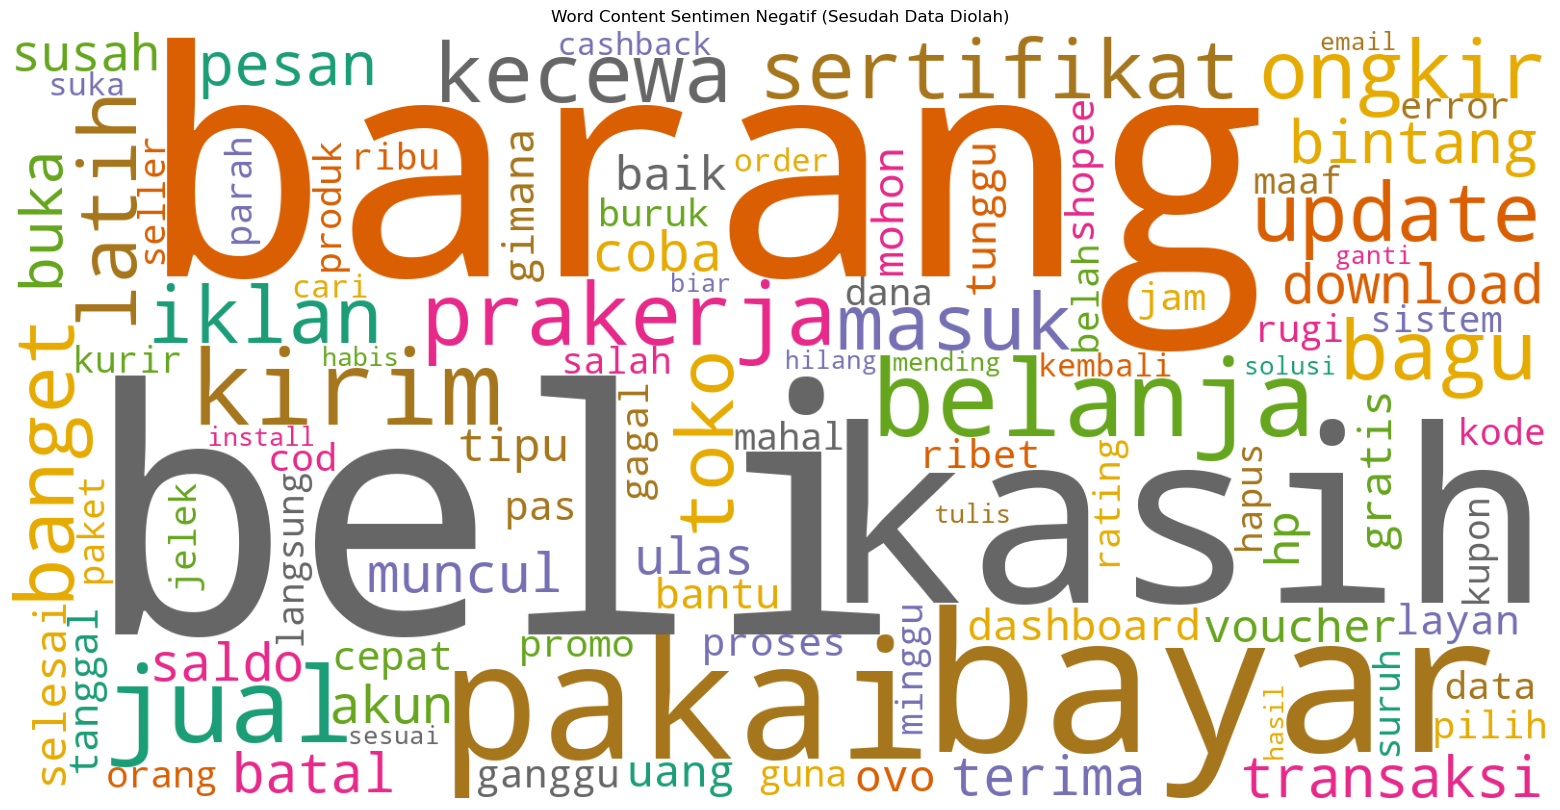

In [44]:
# 1. WORDCLOUD CONTENT SENTIMEN NEGATIF (SESUDAH DIOLAH)

#tokped_sudah_stemming["content_clean"].astype("str")

word_sesudah_diolah_negatif = pd.Series(" ".join(content_isi[content_isi["sentimen"] == 0]["content_clean_tanpax"].astype("str")).split())
dat_sesudah_diolah_negatif = " ".join(word_sesudah_diolah_negatif)

# Unigram (per satu kata) -> "collocations = False"
wordcloud_ssdh_negatif = WordCloud(background_color = "white", mode = "RGB", width = 1600, height = 800, colormap = "Dark2", collocations = False, max_words = 100).generate(dat_sesudah_diolah_negatif)
plt.figure(figsize = (20, 10))
plt.title("Word Content Sentimen Negatif (Sesudah Data Diolah)")
plt.imshow(wordcloud_ssdh_negatif)
plt.axis("off")

plt.savefig("Visualisasi/Wordcloud Data Clean Sentimen Negatif.png")

plt.show()

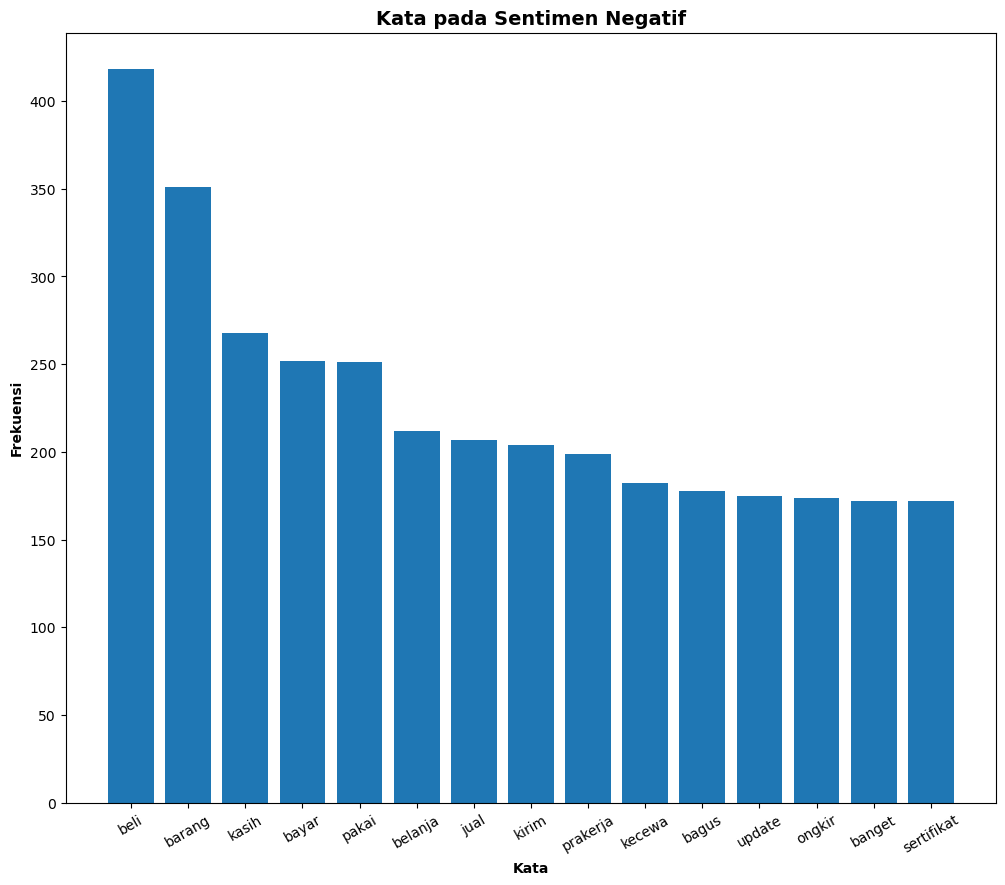

In [17]:
# SENTIMEN NEGATIF

negatif_kata = word_sesudah_diolah_negatif.value_counts().nlargest(15)

negatif_x = negatif_kata.index
negatif_y = negatif_kata.values

plt.figure(figsize = (12, 10))
plt.bar(negatif_x, negatif_y)
plt.xlabel("Kata", fontweight ='bold')
plt.ylabel("Frekuensi", fontweight ='bold')
plt.title("Kata pada Sentimen Negatif", fontweight ='bold', fontsize = 14)

plt.xticks(negatif_x, rotation = 30)

plt.savefig('Visualisasi/Top Words Sentimen Negatif.png')

plt.show()

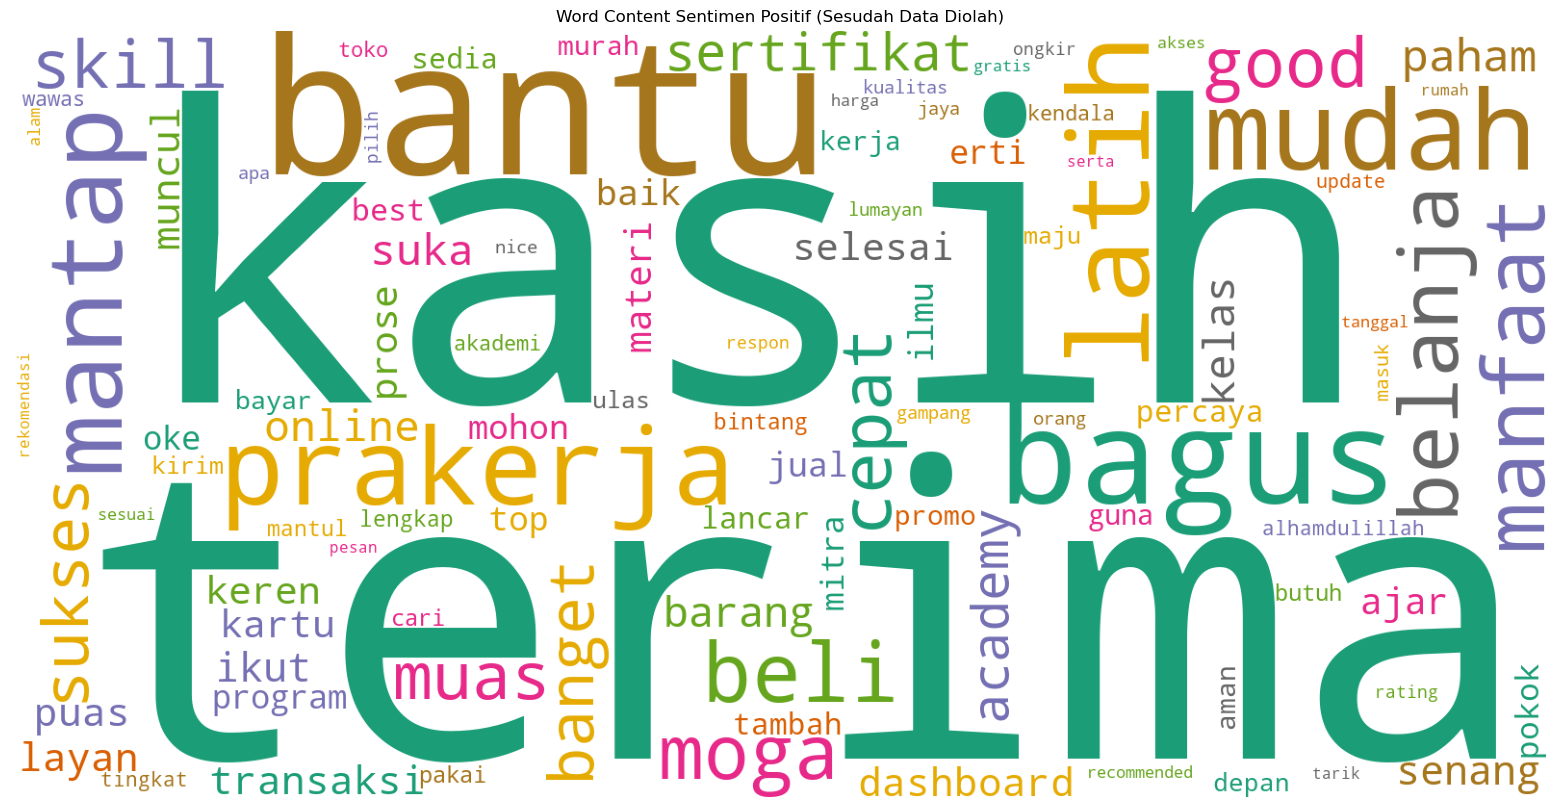

In [18]:
# 2. WORDCLOUD CONTENT SENTIMEN POSITIF (SESUDAH DIOLAH)

#tokped_sudah_stemming["content_clean"].astype("str")

word_sesudah_diolah_positif = pd.Series(" ".join(content_isi[content_isi["sentimen"] == 1]["content_clean_tanpax"].astype("str")).split())
dat_sesudah_diolah_positif = " ".join(word_sesudah_diolah_positif)

# Unigram (per satu kata) -> "collocations = False"
wordcloud_ssdh_positif = WordCloud(background_color = "white", mode = "RGB", width = 1600, height = 800, colormap = "Dark2", collocations = False, max_words = 100).generate(dat_sesudah_diolah_positif)
plt.figure(figsize = (20, 10))
plt.title("Word Content Sentimen Positif (Sesudah Data Diolah)")
plt.imshow(wordcloud_ssdh_positif)
plt.axis("off")

plt.savefig("Visualisasi/Wordcloud Data Clean Sentimen Positif.png")

plt.show()

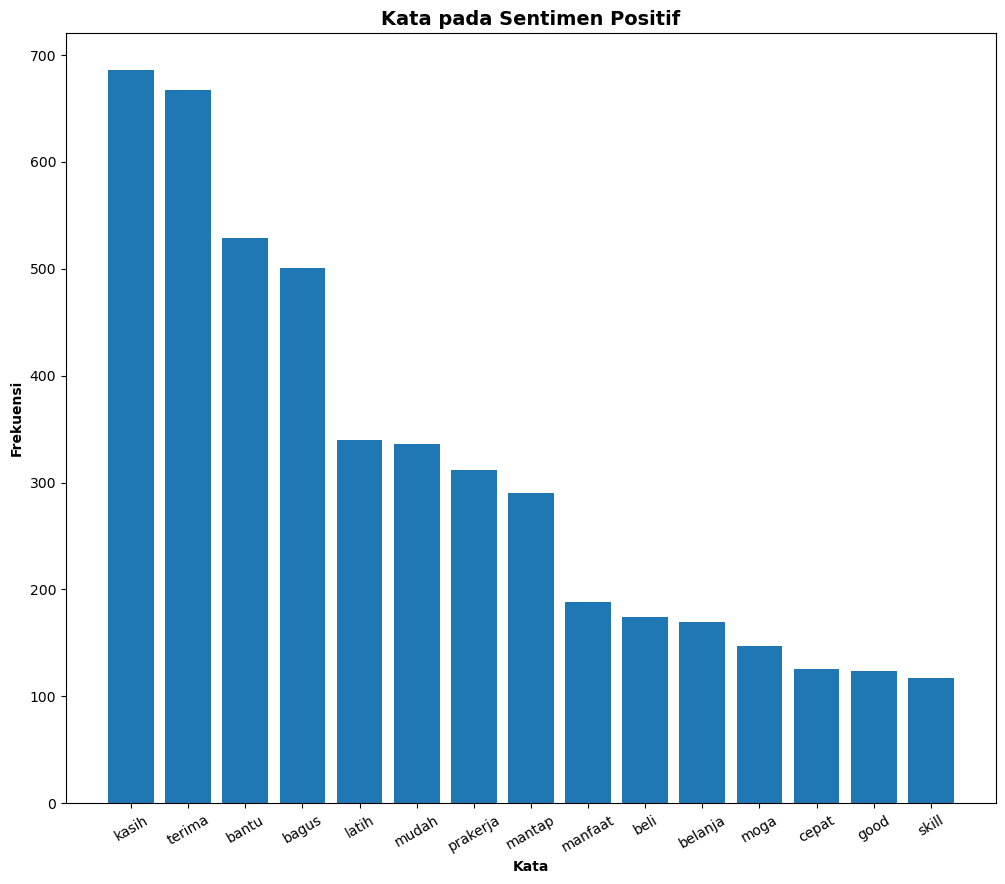

In [19]:
# SENTIMEN POSITIF

positif_kata = word_sesudah_diolah_positif.value_counts().nlargest(15)

positif_x = positif_kata.index
positif_y = positif_kata.values

plt.figure(figsize = (12, 10))
plt.bar(positif_x, positif_y)
plt.xlabel("Kata", fontweight ='bold')
plt.ylabel("Frekuensi", fontweight ='bold')
plt.title("Kata pada Sentimen Positif", fontweight ='bold', fontsize = 14)

plt.xticks(positif_x, rotation = 30)

plt.savefig('Visualisasi/Top Words Sentimen Positif.png')

plt.show()

## TF-IDF

In [20]:
X = content_isi["content_clean_tanpax"]
y = content_isi["sentimen"]

In [21]:
print(X.shape)
print(y.shape)

(5654,)
(5654,)


In [22]:
# INI BUAT YANG K-FOLD CROSS VALIDATION
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(X)

print(X.shape) # Banyak kolom = Banyak kata yang ada dalam keseluruhan dokumen (content)

(5654, 4855)


In [77]:
# Simpan vectorizer dalam bentuk pickle
with open("vectorizer_tfidf.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

## MODELLING DAN EVALUASI

In [56]:
# INI BUAT YANG K-FOLD CROSS VALIDATION
# MODELLING dan EVALUASI

# Membuat model menggunakan SVC (SVM Classification)
from sklearn.svm import SVC
svc = SVC(kernel = "linear")

# PAKAI CROSS VAL
from sklearn.model_selection import cross_val_score
accuracies_svc = cross_val_score(estimator = svc, X = X, y = y, cv = 10)
print("Nilai Akurasi SVM 10-Fold: {:.2f}%".format(accuracies_svc.mean() * 100))

Nilai Akurasi SVM 10-Fold: 87.19%


In [64]:
svc.fit(X, y)

SVC(kernel='linear')

In [65]:
list_akurasi = list(accuracies_svc * 100)
list_akurasi

[87.45583038869258,
 89.04593639575971,
 88.33922261484098,
 88.33922261484098,
 87.07964601769912,
 86.90265486725663,
 88.14159292035399,
 85.13274336283186,
 84.070796460177,
 87.43362831858407]

In [66]:
list_akurasi2 = []
for i in list_akurasi:
    list_akurasi2.append(round(i, 2))

list_akurasi2

[87.46, 89.05, 88.34, 88.34, 87.08, 86.9, 88.14, 85.13, 84.07, 87.43]

In [67]:
np.array(list_akurasi2).mean() # Hasilnya sama

87.194

In [68]:
# Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(svc, X, y, cv = 10)
conf_mat = confusion_matrix(y, y_pred)

In [69]:
conf_mat

array([[2561,  316],
       [ 408, 2369]])

In [70]:
(2561 + 2369) / (2561 + 2369 + 408 + 316) # Akurasi hasilnya sama

0.8719490626105412

In [71]:
316+2369

2685

In [72]:
# Simpan model dalam bentuk pickle
with open("model_svc.pkl", "wb") as f:
    pickle.dump(svc, f)

## FUNGSI UNTUK MENENTUKAN PREDIKSI SENTIMEN

In [7]:
# Kumpulkan semua function yang telah dibuat

# Case Folding
def clean_content(content):
    import string, re
    content = content.lower() # menjadikan lowercase
    content = re.sub("[^a-z]", " ", content) # hapus semua karakter kecuali a-z
    content = re.sub("\t", " ", content) # mengganti tab dengan spasi
    content = re.sub("\n", " ", content) # mengganti new line dengan spasi
    content = re.sub("\s+", " ", content) # mengganti spasi > 1 dengan 1 spasi
    content = content.strip() # menghapus spasi di awal dan akhir 
    return content


# Koreksi Penulisan
# PAKAI WORD BREAK (\b)
def koreksi_penulisan(content):
    import re
    dict_koreksi = {}
    file = open("list koreksi penulisan (tambahan sendiri).txt")
    
    for x in file:
        f = x.split(":")
        dict_koreksi.update({f[0].strip(): f[1].strip()})
    
    for awal, pengganti in dict_koreksi.items():
        #content = str(content).replace(awal, pengganti)
        content = re.sub(r"\b" + awal + r"\b", pengganti, content)
    return content

    
# Stopword Removal
def clean_stopword(content):
    # Stopword Sastrawi
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
    factory = StopWordRemoverFactory()
    stopword_sastrawi = factory.get_stop_words()
    content = content.split() # split jadi kata per kata
    content = [w for w in content if w not in stopword_sastrawi] # hapus stopwords
    content = " ".join(w for w in content) # join semua kata yang bukan stopwords

    # Stopword NLTK
    import nltk
    #nltk.download()
    from nltk.corpus import stopwords
    stopword_nltk = set(stopwords.words("indonesian"))
    stopword_nltk = stopword_nltk
    content = content.split() # split jadi kata per kata
    content = [w for w in content if w not in stopword_nltk] # hapus stopwords
    content = " ".join(w for w in content) # join semua kata yang bukan stopwords
    return content


# Stopword Tambahan
def clean_stopword_tambahan(content):
    with open("list stopword baru (tambahan sendiri).txt", "r") as f: 
        stopwords_tambahan = f.read().splitlines()
    content = content.split() # split jadi kata per kata
    content = [w for w in content if w not in stopwords_tambahan] # hapus stopwords
    content = " ".join(w for w in content) # join semua kata yang bukan stopwords
    return content


# Stemming
def clean_stem(content):
    # Stemming Sastrawi
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    factory = StemmerFactory()
    stemmer_sastrawi = factory.create_stemmer()
    content = stemmer_sastrawi.stem(content)
    return content


# Clean Tokped
stopwords_tokped = ["tokopedia", "aplikasi"]
def clean_tokped(text):
    temp = text.split() # split words
    temp = [w for w in temp if not w in stopwords_tokped] # remove stopwords
    temp = " ".join(word for word in temp) # join all words
    return temp

In [8]:
# Function gabungan semua proses
# Nanti untuk run data/content yang akan dites

def prediksi_sentimen(df_content):
    # 1. membersihkan content
    df_content = df_content.apply(clean_content)
    
    # 2. koreksi penulisan
    df_content = df_content.apply(koreksi_penulisan)
    
    # 3. hapus stopwords
    df_content = df_content.apply(clean_stopword)
    df_content = df_content.apply(clean_stopword_tambahan)
    
    # 4. stemming
    df_content = df_content.apply(clean_stem)
    
    # 5. hapus stopword tokped
    df_content = df_content.apply(clean_tokped)
    
    # 6. vectorizer
    with open("vectorizer_tfidf.pkl", "rb") as f:
        vectorizer = pickle.load(f)
    df_content = vectorizer.transform(df_content)
    
    # 7. predict
    with open("model_svc.pkl", "rb") as f:
        svc = pickle.load(f)
    pred_sentimen = svc.predict(df_content)
    
    return pred_sentimen

In [9]:
list_coba_review = ["Tokped aplikasi yang keren",
                    "Kualitas barang bagus dan harga murah", 
                    "Sudah baik",
                    "Fitur masih banyak yang gangguan", 
                    "Respon apk lama"]

df_coba_review = pd.DataFrame(list_coba_review, columns = ["coba_review"])
df_coba_review

,coba_review
0,Tokped aplikasi yang keren
1,Kualitas barang bagus dan harga murah
2,Sudah baik
3,Fitur masih banyak yang gangguan
4,Respon apk lama


In [10]:
prediksi_sentimen(df_coba_review["coba_review"])

array([1, 1, 0, 0, 0])